In [1]:
import glob
import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd

In [2]:
radius = 'ak7' # Jet radius to use. Either 'ak5' or 'ak7'

In [3]:
inputs = {}
inputs['QCD']  = glob.glob('data/{}/{}PFJetsParams0*.npy'.format(radius, radius))
list_params = {}
params = {}
for key, input_files in inputs.iteritems():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print 'bad file: %s'%in_file
    params[key] = np.concatenate(list_params[key])

In [4]:
print params['QCD'].dtype.names

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'genXsec', 'pthat', 'mcweight', 'njet', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_area', 'jet_jes', 'gen_pt', 'jet_gen_dr', 'chf', 'nhf', 'phf', 'elf', 'muf', 'hf_hf', 'hf_phf', 'hf_hm', 'hf_phm', 'chm', 'nhm', 'phm', 'elm', 'mum', 'beta', 'bstar', 'pfcand_pt', 'pfcand_eta', 'pfcand_phi', 'pfcand_id', 'pfcand_charge', 'pfcand_ijet')


In [5]:
df_jet = {}
df_cand = {}
for QCDBin in ['QCD']:
    df_jet[QCDBin] = pd.DataFrame(params[QCDBin],columns=['run','lumi','event','met','sumet','rho','pthat','mcweight','njet','jet_pt','jet_eta','jet_phi','jet_E','jet_area','jet_jes','gen_pt','jet_gen_dr',
                                                          'chf','nhf','phf','elf','muf','hf_hf','hf_phf','hf_hm','hf_phm','chm','nhm','phm','elm','mum','beta','bstar','pfcand_ijet'])
    df_jet[QCDBin] = df_jet[QCDBin].drop_duplicates()
    df_jet[QCDBin] = df_jet[QCDBin][(df_jet[QCDBin].jet_pt > 80)]
    df_cand[QCDBin] = pd.DataFrame(params[QCDBin], columns=['event', 'jet_pt', 'jet_eta', 'jet_phi','pfcand_pt', 'pfcand_eta', 'pfcand_phi', 'pfcand_id', 'pfcand_charge', 'pfcand_ijet'])
    df_cand[QCDBin] = df_cand[QCDBin][(df_cand[QCDBin].jet_pt > 80)]

In [6]:
df_jets = df_jet['QCD']
df_cands = df_cand['QCD']

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

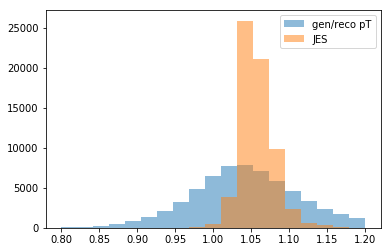

In [8]:
plt.figure()
bins=np.linspace(0.8,1.2,20)
plt.hist(df_jets['gen_pt']/df_jets['jet_pt'], label='gen/reco pT', alpha=0.5, bins=bins)
plt.hist(df_jets['jet_jes'], label='JES', alpha=0.5, bins=bins)
plt.legend()
plt.show()

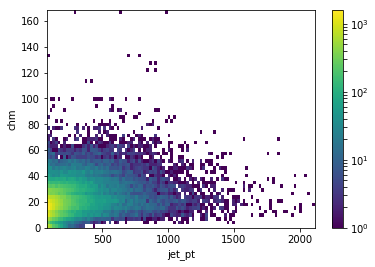

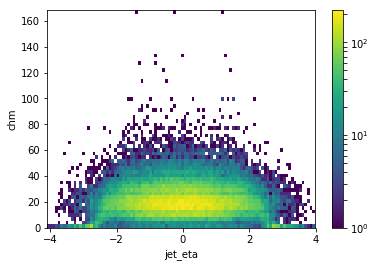

In [9]:
plt.figure()
plt.hist2d(df_jets['jet_pt'], df_jets['chm'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('jet_pt')
plt.ylabel('chm')
plt.show()
plt.figure()
plt.hist2d(df_jets['jet_eta'], df_jets['chm'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('jet_eta')
plt.ylabel('chm')
plt.show()

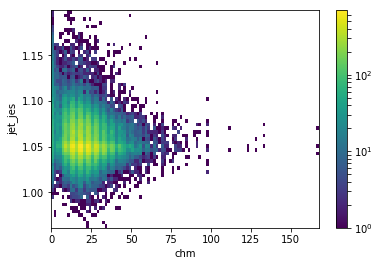

In [10]:
plt.figure()
plt.hist2d(df_jets['chm'], df_jets['jet_jes'], bins=(100, 60), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.ylabel('jet_jes')
plt.xlabel('chm')
plt.show()

/usr/lib64/python2.7/dist-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


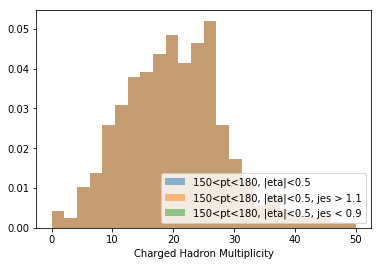

In [11]:
plt.figure()
bins = np.linspace(0, 50, 25)
plt.hist(df_jets['chm'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5)], bins, label='150<pt<180, |eta|<0.5', alpha=0.5, normed=True)
plt.hist(df_jets['chm'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5) &
                             (df_jets['jet_jes'] > 1.0)], bins, label='150<pt<180, |eta|<0.5, jes > 1.1', alpha=0.5, normed=True)
plt.hist(df_jets['chm'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5) &
                             (df_jets['jet_jes'] < 1.0)], bins, label='150<pt<180, |eta|<0.5, jes < 0.9', alpha=0.5, normed=True)
plt.xlabel('Charged Hadron Multiplicity')
plt.legend(loc='lower right')
plt.show()

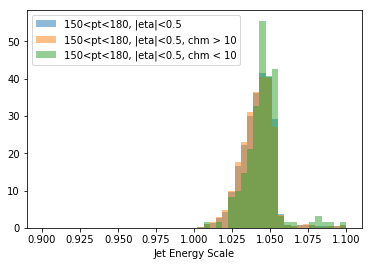

In [13]:
plt.figure()
bins = np.linspace(0.9, 1.1, 50)
plt.hist(df_jets['jet_jes'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5)], bins, label='150<pt<180, |eta|<0.5', alpha=0.5, normed=True)
plt.hist(df_jets['jet_jes'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5) &
                             (df_jets['chm'] > 10)], bins, label='150<pt<180, |eta|<0.5, chm > 10', alpha=0.5, normed=True)
plt.hist(df_jets['jet_jes'][(df_jets['jet_pt']>150) & 
                             (df_jets['jet_pt']<180) & 
                             (df_jets['jet_eta']>-0.5) & 
                             (df_jets['jet_eta']<0.5) &
                             (df_jets['chm'] < 10)], bins, label='150<pt<180, |eta|<0.5, chm < 10', alpha=0.5, normed=True)
plt.xlabel('Jet Energy Scale')
plt.legend(loc='upper left')
plt.show()

In [14]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm 
    return x / (K.sqrt(K.mean(K.square(x)))+1e-5)

In [15]:
####################
# Global Variables #
####################
nx = 25 if radius == 'ak5' else 30 # size of image in eta
ny = 25 if radius == 'ak5' else 30 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

In [16]:
from keras import backend as K
list_x = []
list_y = []
list_w = []
njets = 0
# 4D tensor
# 1st dim is jet index, 2nd dim is pt value (or rgb, etc.), 3rd dim is eta bin, 4th dim is phi bin
if K.image_dim_ordering()=='tf':
    jet_images = np.zeros((len(df_jets), nx, ny, 1))
else:
    jet_images = np.zeros((len(df_jets), 1, nx, ny))

for i in range(0, len(df_jets)):
    njets+=1
    #get the ith jet 
    df_cand_i = df_cands[(df_cands['pfcand_ijet'] == df_jets['pfcand_ijet'].iloc[i]) &
                                   (df_cands['event'] == df_jets['event'].iloc[i]) &
                                   (df_cands['jet_pt'] == df_jets['jet_pt'].iloc[i])]
    x = df_cand_i['pfcand_eta']-df_cand_i['pfcand_eta'].iloc[0]
    y = df_cand_i['pfcand_phi']-df_cand_i['pfcand_phi'].iloc[0]
    weights = df_cand_i['pfcand_pt'] # pt of candidate is the weight
    #x,y = rotate_and_reflect(x,y,weights)
    list_x.append(x)
    list_y.append(y)
    list_w.append(weights)
    hist, xedges, yedges = np.histogram2d(x.values, y.values, weights=weights, bins=(xbins,ybins))
    for ix in range(0,nx):
        for iy in range(0,ny):
            if K.image_dim_ordering()=='tf':
                jet_images[i,ix,iy,0] = hist[ix,iy]
            else:
                jet_images[i,0,ix,iy] = hist[ix,iy]
all_x = np.concatenate(list_x)
all_y = np.concatenate(list_y)
all_w = np.concatenate(list_w)
all_w = 1.*all_w/njets # to get average

Using TensorFlow backend.


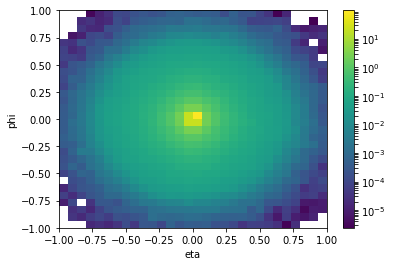

In [17]:
plt.figure('W')
plt.hist2d(all_x, all_y, weights=all_w, bins=(xbins,ybins), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('eta')
plt.ylabel('phi')
plt.show()

In [18]:
jet_images.shape

(64569, 30, 30, 1)

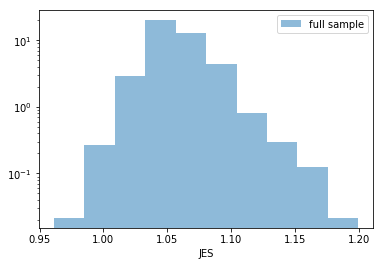

In [19]:
plt.hist(df_jets['jet_jes'], label='full sample', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel('JES')
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_jets['jet_pt'] = scaler.fit_transform(df_jets['jet_pt'].reshape(-1,1))
# normalize jet eta
df_jets['jet_eta'] /= 2.5
#normalize jet phi
df_jets['jet_phi'] /= 3.14

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Add 'jet images' column to dataframe
tmp_images = [x for x in jet_images]
df_jets['jet_images'] = tmp_images

In [22]:
print(df_jets.columns)
print(df_jets['jet_images'].shape)
print(df_jets['jet_images'].iloc[0].shape)

Index([u'run', u'lumi', u'event', u'met', u'sumet', u'rho', u'pthat',
       u'mcweight', u'njet', u'jet_pt', u'jet_eta', u'jet_phi', u'jet_E',
       u'jet_area', u'jet_jes', u'gen_pt', u'jet_gen_dr', u'chf', u'nhf',
       u'phf', u'elf', u'muf', u'hf_hf', u'hf_phf', u'hf_hm', u'hf_phm',
       u'chm', u'nhm', u'phm', u'elm', u'mum', u'beta', u'bstar',
       u'pfcand_ijet', u'jet_images'],
      dtype='object')
(64569,)
(30, 30, 1)


In [23]:
df_jets.to_pickle('data/{}/df_jets_{}.pkl'.format(radius, radius))